In [1]:
import numpy as np
from scipy.sparse import lil_array, csr_array
from scipy.sparse.linalg import spsolve
from math import ceil, sqrt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10, 15)
plt.rcParams["figure.dpi"]= 200
plt.set_cmap("plasma")

<Figure size 2000x3000 with 0 Axes>

## Function definitions

### Geometry init
The geometry is a grid of lambda values(Thermal conductivity in [w/(m*k)]), set up with the nodes in the middle of each grid square.

In [2]:
def init_l(dx, width, geo):
    """
    Initialize the geometry array 'l' based on the provided parameters.

    Args:
    dx (float): The spacing or resolution for discretizing the 'l' array.
    width (float): The width of the 'l' array.
    geo (list): A list describing the geometry of the system.
                Each element in the list should be a sublist with the format:
                [height, lambda_value, cap_info]
                where 'height' is the height of the geometry layer,
                'lambda_value' is the corresponding lambda value,
                and 'cap_info' is an optional sublist with capillary information.
                The capillary information should have the format:
                [r1, r2, cap_offset, lambda_cap],
                where 'r1' and 'r2' are the inner and outter radii of the capillary,
                'cap_offset' is the offset from the lower bound of the layer,
                and 'lambda_cap' is the lambda value for the capillary.

    Returns:
    l (numpy.ndarray): The geometry array 'l' with lambda values.
    water_mask (numpy.ndarray): A binary array denoting water locations.
    center (float): The center position of the capillary segment.

    Note:
    - The lambda value for water is set to a default value of 0.6089.
    - The 'water_mask' array is a binary array with True values representing water locations.
    """
    l_water = 0.6089 #from wiki
    #Initialize the geometry array of l(i, j)
    #calculate total system height
    height = sum([sublist[0] for sublist in geo])
    l = np.zeros((int(height/dx), int(width/dx)))
    
    #Fill the geometry array
    lower_bound = 0
    for i in geo:
        l_height = int(i[0]/dx)
        l[lower_bound:(lower_bound+l_height)] = i[1]

        #Fill in capillary
        if len(i) == 3:
            cap_info = i[2]

            # Extract capillary information and set variables
            r1 = cap_info[0] / dx # Inner radius of capillary
            r2 = cap_info[1] / dx  # Outer radius of capillary
            cap_offset = int(lower_bound + cap_info[2]/dx) # Lower bound of capillary
            cap_high = int(cap_offset+2*r2)  # Upper bound of capillary height
            center = cap_offset  + r2 # Center of the capillary
            
            # Create 2D distance array
            ly, lx = np.ogrid[cap_offset:cap_high+1, 0:ceil(2*r2)+1]
            dist = np.sqrt((ly - center) ** 2 + lx ** 2)
            
            # Fudge coefficient, helps to fill all elements
            eps = 0.25
            
            # Set lambda in the Water zone
            l[cap_offset:cap_high + 1, 0:ceil(2 * r2) + 1][dist <= r1] = l_water

            # Set capillary lambda
            l[cap_offset:cap_high + 1, 0:ceil(2 * r2) + 1][np.logical_and(r1 - eps < dist, dist < r2 + eps)] = cap_info[-1]
            


        lower_bound += l_height
    
    #Make binary water mask
    water_mask = l==l_water

    return l, water_mask, center

## Linear system of equations

Now that the medium has been discretized,
i use FDM to aproximate $\nabla (\lambda \nabla T ) = 0 $.
The equation as solved:

$$
\frac{2}{k^{-1}_L+k^{-1}} (T_{i,j-1}-T_{i,j})+\frac{2}{k^{-1}_R+k^{-1}} (T_{i,j+1}-T_{i,j})
+\frac{2}{k^{-1}_T+k^{-1}} (T_{i+1,j}-T_{i,j})+\frac{2}{k^{-1}_B+k^{-1}} (T_{i-1,j}-T_{i,j})
=0
$$
with T as temperature(kelvion or celsisus)(i=y,j=x), k as thermal conductivity of the nodes own grid cell or neighbour with: T - top, B - bottom, L - left, R - right. 
Each of the terms describes a heat flux to a neighboring node.

and build a system of linear equations to solve for the stationary state:

$AT=b$

with A as the matrix of coefficients, T as the unknown temperature vector and b as the source term vector.

### Implemented boundary conditions and "ghost cells"
These are specific to the capillary problem i was solving.

#### Bottom

Neumann Boundary Condition (Type II), 
requiers a ghost cell to impose the heat flux, this is where the padding comes in.

$\frac{\delta T}{\delta y}_{y=0} = \frac{q}{\lambda}$


#### Top

At the top boundary, a fixed temperature or convective boundary condition can be specified, simulating different scenarios encountered in practical applications.
Fixed temperature dosent require an aditonal layer, just that the boundary layer is set to
the fixed temperature.
But convective boundary requires a ghost cell for the temperature at infinity and to impose the prescribed flux.
The convection is described by:

$\frac{\delta T}{\delta y}_{y=top} = \alpha(T-T_0)$

With $\alpha$ as the convective constant, T as temperature of a boundary element of the medium and $T_0$ as temperature at infinity.

#### Sides

Sides have no heat flux trought them (also Type II), can be tiled to reconstruct a view of the wall cross-section.

### Sparse Arrays

Because the size of the coefficent matrix scalles as '(nx*ny, nx*ny)',
it quiet quickly becomes too large as a numpy array to be held in ram.

for example `np.zeros((100*1500,100*1500))` yields:

`MemoryError: Unable to allocate 168. GiB for an array with shape (150000, 150000) and data type float64`

But its mostly zeros - a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix),
so `scipy.sparse` is used.

In [3]:
def init_Ab(l, t_top, t_water, water_mask, q, dx, l_top=None):  
    """
    Initialize the coefficient matrix A, the solution vector b, and the padding value for the heat equation solver.

    Args:
        l (ndarray): Geometry array of size (ny, nx) representing the thermal conductivity at each grid point.
        t_top (float): Temperature at the top boundary.
        t_water (float): Temperature of the water.
        water_mask (ndarray): Binary array indicating the locations of water cells in the grid.
        q (float): Heat flow at the bottom boundary.
        dx (float): Grid spacing.
        l_top (float, optional): Thermal conductivity at the top boundary for optional convective boundary condition. Defaults to None.

    Returns:
        csr_matrix: Coefficient matrix A of size (N, N), where N is the total number of grid points.
        ndarray: Solution vector b of size (N,).
        int: Padding value (1 or 2) used for grid shape modification.

    Notes:
        - This function initializes the coefficient matrix A, the solution vector b, and determines the required padding for the grid based on the input parameters.
        - The heat equation is solved on a 2D grid with ny rows and nx columns.
        - The function handles both Dirichlet and convective boundary conditions.
        - For Dirichlet boundary conditions, the temperature values at the boundaries are fixed.
        - For convective boundary conditions, a convective heat flow term is added to the top boundary.
    """
    # Define the grid parameters
    ny, nx = l.shape
    
    # Shape modification for padding
    if l_top == None:
        pad = 1
        ny += pad # Padding for bottom ghost cell
    else:
        pad = 2
        ny += pad # Adds padding for top ghost cell
    
    # Create the coefficient matrix A and vector b
    A = lil_array((nx*ny, nx*ny))
    b = np.zeros((nx*ny))

    
    # Pad l to avoid indexing problems
    line = l[0]
    l = np.vstack((line,l))
    if pad == 2:
        line = l[-1]
        l = np.vstack((l,line))
    
    # Pad water_mask
    line = water_mask[0]
    water_mask = np.vstack((line,water_mask))
    if pad == 2:
        line = water_mask[-1]
        water_mask = np.vstack((water_mask,line))

    
    # SET Constants in b
    # Top
    b[(len(b)-nx):] = t_top
        
    # Water
    b[water_mask.flatten()] = t_water

    
    # Bottom boundary derivative
    b[:nx] = -(0.1/1000)*q/l[1,-1] #h*q/lambda  #q is in (w/m^2), i take its as h thick

    
    #SET A

    #Constant T top bc
    if l_top == None:
        print("CONSTANT BC")
        
        # Medium
        for i in range(1,ny-1):
            for j in range(1,nx-1):
                k = i*nx+j

                if not water_mask[i,j]:
                    ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
                    im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
                    jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
                    jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
                    diagonal = -(ip+im+jp+jm)

                    A[k,k] = diagonal
                    A[k,k+nx] = ip
                    A[k,k-nx] = im
                    A[k,k+1] = jp
                    A[k,k-1] = jm

                # Constant for water
                else:
                    A[k,k]=1 # This misses first elements of each row of water_mask because of j range

        # Sides is 3 element average with k corrected coefficents
        for i in range(1,ny-1):
            # Left
            if not water_mask[i,0]:
                k = i*nx
                ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
                im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
                jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
                diagonal = -(ip+im+jp)

                A[k,k] = diagonal
                A[k,k+nx] = ip
                A[k,k-nx] = im
                A[k,k+1] = jp

            else:
                k = i*nx
                A[k,k] = 1 #water mask first element fix
   
            # Right
            k = i*nx+nx-1
            ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
            im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
            jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
            diagonal = -(ip+im+jm)

            A[k,k] = diagonal
            A[k,k+nx] = ip
            A[k,k-nx] = im
            A[k,k-1] = jm

        #Bottom derivative (q bc) and top bc
        for j in range(0,nx):
            k = j
            A[k,k] = 1
            A[k,k+nx] = -1

            #Top is constant temp (includig when convective bc)
            k = (ny-1)*nx+j
            A[k,k] = 1
        
        
    #Convective top bc
    else:
        print("CONVECTIVE BC")
        
        # Top 
        i = ny-2
        for j in range(1,nx-1):
                k = i*nx+j
                # Convective heat flow
                ip = ((0.1/1000)*l_top) #i+1,j #sussy
                
                im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
                jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
                jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
                diagonal = -(ip+im+jp+jm)

                A[k,k] = diagonal
                A[k,k+nx] = ip
                A[k,k-nx] = im
                A[k,k+1] = jp
                A[k,k-1] = jm
        
        # Top corner elements
        # Left
        j = 0
        k = i*nx+j
        
        ip = ((0.1/1000)*l_top) #i+1,j
        im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
        jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
        diagonal = -(ip+im+jp)
        
        A[k,k] = diagonal
        A[k,k+nx] = ip
        A[k,k-nx] = im
        A[k,k+1] = jp
        
        # Right
        j = nx-1
        k = i*nx+j
        ip = ((0.1/1000)*l_top) #i+1,j

        im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
        jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
        diagonal = -(ip+im+jm)
        
        A[k,k] = diagonal
        A[k,k+nx] = ip
        A[k,k-nx] = im
        A[k,k-1] = jm
            
        # Medium
        for i in range(1,ny-2):
            for j in range(1,nx-1):
                k = i*nx+j

                if not water_mask[i,j]:
                    ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
                    im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
                    jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
                    jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
                    diagonal = -(ip+im+jp+jm)

                    A[k,k] = diagonal
                    A[k,k+nx] = ip
                    A[k,k-nx] = im
                    A[k,k+1] = jp
                    A[k,k-1] = jm
                    
                else:
                    A[k,k]=1
            
        # Sides is 3 element average with k corrected coefficents
        for i in range(1,ny-2):
            # Left
            if not water_mask[i,0]:

                k = i*nx
                ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
                im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
                jp = 2/(1/l[i,j+1]+1/l[i,j]) #i,j+1
                diagonal = -(ip+im+jp)

                A[k,k] = diagonal
                A[k,k+nx] = ip
                A[k,k-nx] = im
                A[k,k+1] = jp

            else:
                k = i*nx
                A[k,k] = 1 # Water mask first element fix
   
            # Right
            k = i*nx+nx-1
            ip = 2/(1/l[i+1,j]+1/l[i,j]) #i+1,j
            im = 2/(1/l[i-1,j]+1/l[i,j]) #i-1,j
            jm = 2/(1/l[i,j-1]+1/l[i,j]) #i,j-1
            diagonal = -(ip+im+jm)

            A[k,k] = diagonal
            A[k,k+nx] = ip
            A[k,k-nx] = im
            A[k,k-1] = jm

            
        #Bottom derivative (q bc) and top bc
        for j in range(0,nx):
            k = j
            A[k,k] = 1
            A[k,k+nx] = -1

            # Top is constant temp (includig when convective bc)
            k = (ny-1)*nx+j
            A[k,k] = 1

                    


    A = A.tocsr()
    
    return A, b, pad

### Temperature fitter function

In [4]:
def t_fit_loop(A, b, pad, l, t_to_fit, t_error, maxiter, water_mask):
    """
    Itteratively fit the water temperature

    Args:
        A (sparse matrix): Coefficient matrix of the linear system.
        b (array): Right-hand side vector of the linear system.
        pad (int): Padding value (1 or 2) used for grid shape modification.
        l (2D array): Geometry matrix.
        t_to_fit (float): Target temperature value to fit.
        t_error (float): Acceptable error for convergence.
        maxiter (int): Maximum number of iterations allowed.
        water_mask (2D boolean array): Mask indicating the water regions.

    Returns:
        T (2D array): Temperature distribution matrix.
        t (float): Water temperature after convergence.
    """
    t = t_to_fit
    ny, nx = l.shape
    
    iteration = 0
    diff = 1
    
    # Pad water_mask
    line = water_mask[0]
    water_mask = np.vstack((line,water_mask))
    if pad == 2:
        line = water_mask[-1]
        water_mask = np.vstack((water_mask,line))
        
    b[water_mask.flatten()] = t_to_fit
    
    while abs(diff)>t_error and iteration < maxiter:
        
        # Solve the linear system
        T = spsolve(A, b)

        # Reshape the solution vector into a 2D array
        if pad == 2:
            T = T[nx:][:-nx].reshape((ny, nx))
        else:
            T = T[nx:].reshape((ny, nx))
            
        # Calculate lower surface temp
        bot_t = T[0].mean()
        
        # Adjust guess
        diff = t_to_fit - bot_t

        iteration+=1
        t += diff
        b[water_mask.flatten()] = t

        print(iteration, diff)
    
    return T, t

### Algomerated temperature fit funtion

In [5]:
def fit_water_t(geo, width, t_to_fit, q, t_top, l_top=None):
    """
    Init and fit water temperature for the desired parameters.

    Args:
        geo (array): Geometry information.
        width (float): Width of the region.
        t_to_fit (float): Target temperature value to fit.
        q (float): Heat flux.
        t_top (float): Temperature at the top boundary.
        l_top (2D array, optional): Top boundary condition.

    Returns:
        t (float): Adjusted target water temperature after convergence.
        T (2D array): Temperature distribution matrix.
    """
    dx = 0.1
    
    # Init geometry
    l, water_mask, center = init_l(dx, width, geo)
    
    # Init eq. system
    A, b, pad = init_Ab(l, t_top, t_to_fit, water_mask, q, dx, l_top)
    
    print("init done")
    
    # Fit desired water temperature
    t_error = 0.001
    maxiter = 20

    T,t = t_fit_loop(A, b, pad, l, t_to_fit, t_error, maxiter, water_mask)
    
    return t, T

# Examples

## Initialisation and compute to fit capillary water temp to system parameters

CPU times: user 3.07 ms, sys: 2.79 ms, total: 5.85 ms
Wall time: 3.64 ms
CONVECTIVE BC
CPU times: user 1.77 s, sys: 55.7 ms, total: 1.83 s
Wall time: 1.83 s
1 4.391886435164082
2 0.037307025174833086
3 0.00031690576429355133
CPU times: user 3.01 s, sys: 271 ms, total: 3.28 s
Wall time: 3.29 s
34.42951036610321


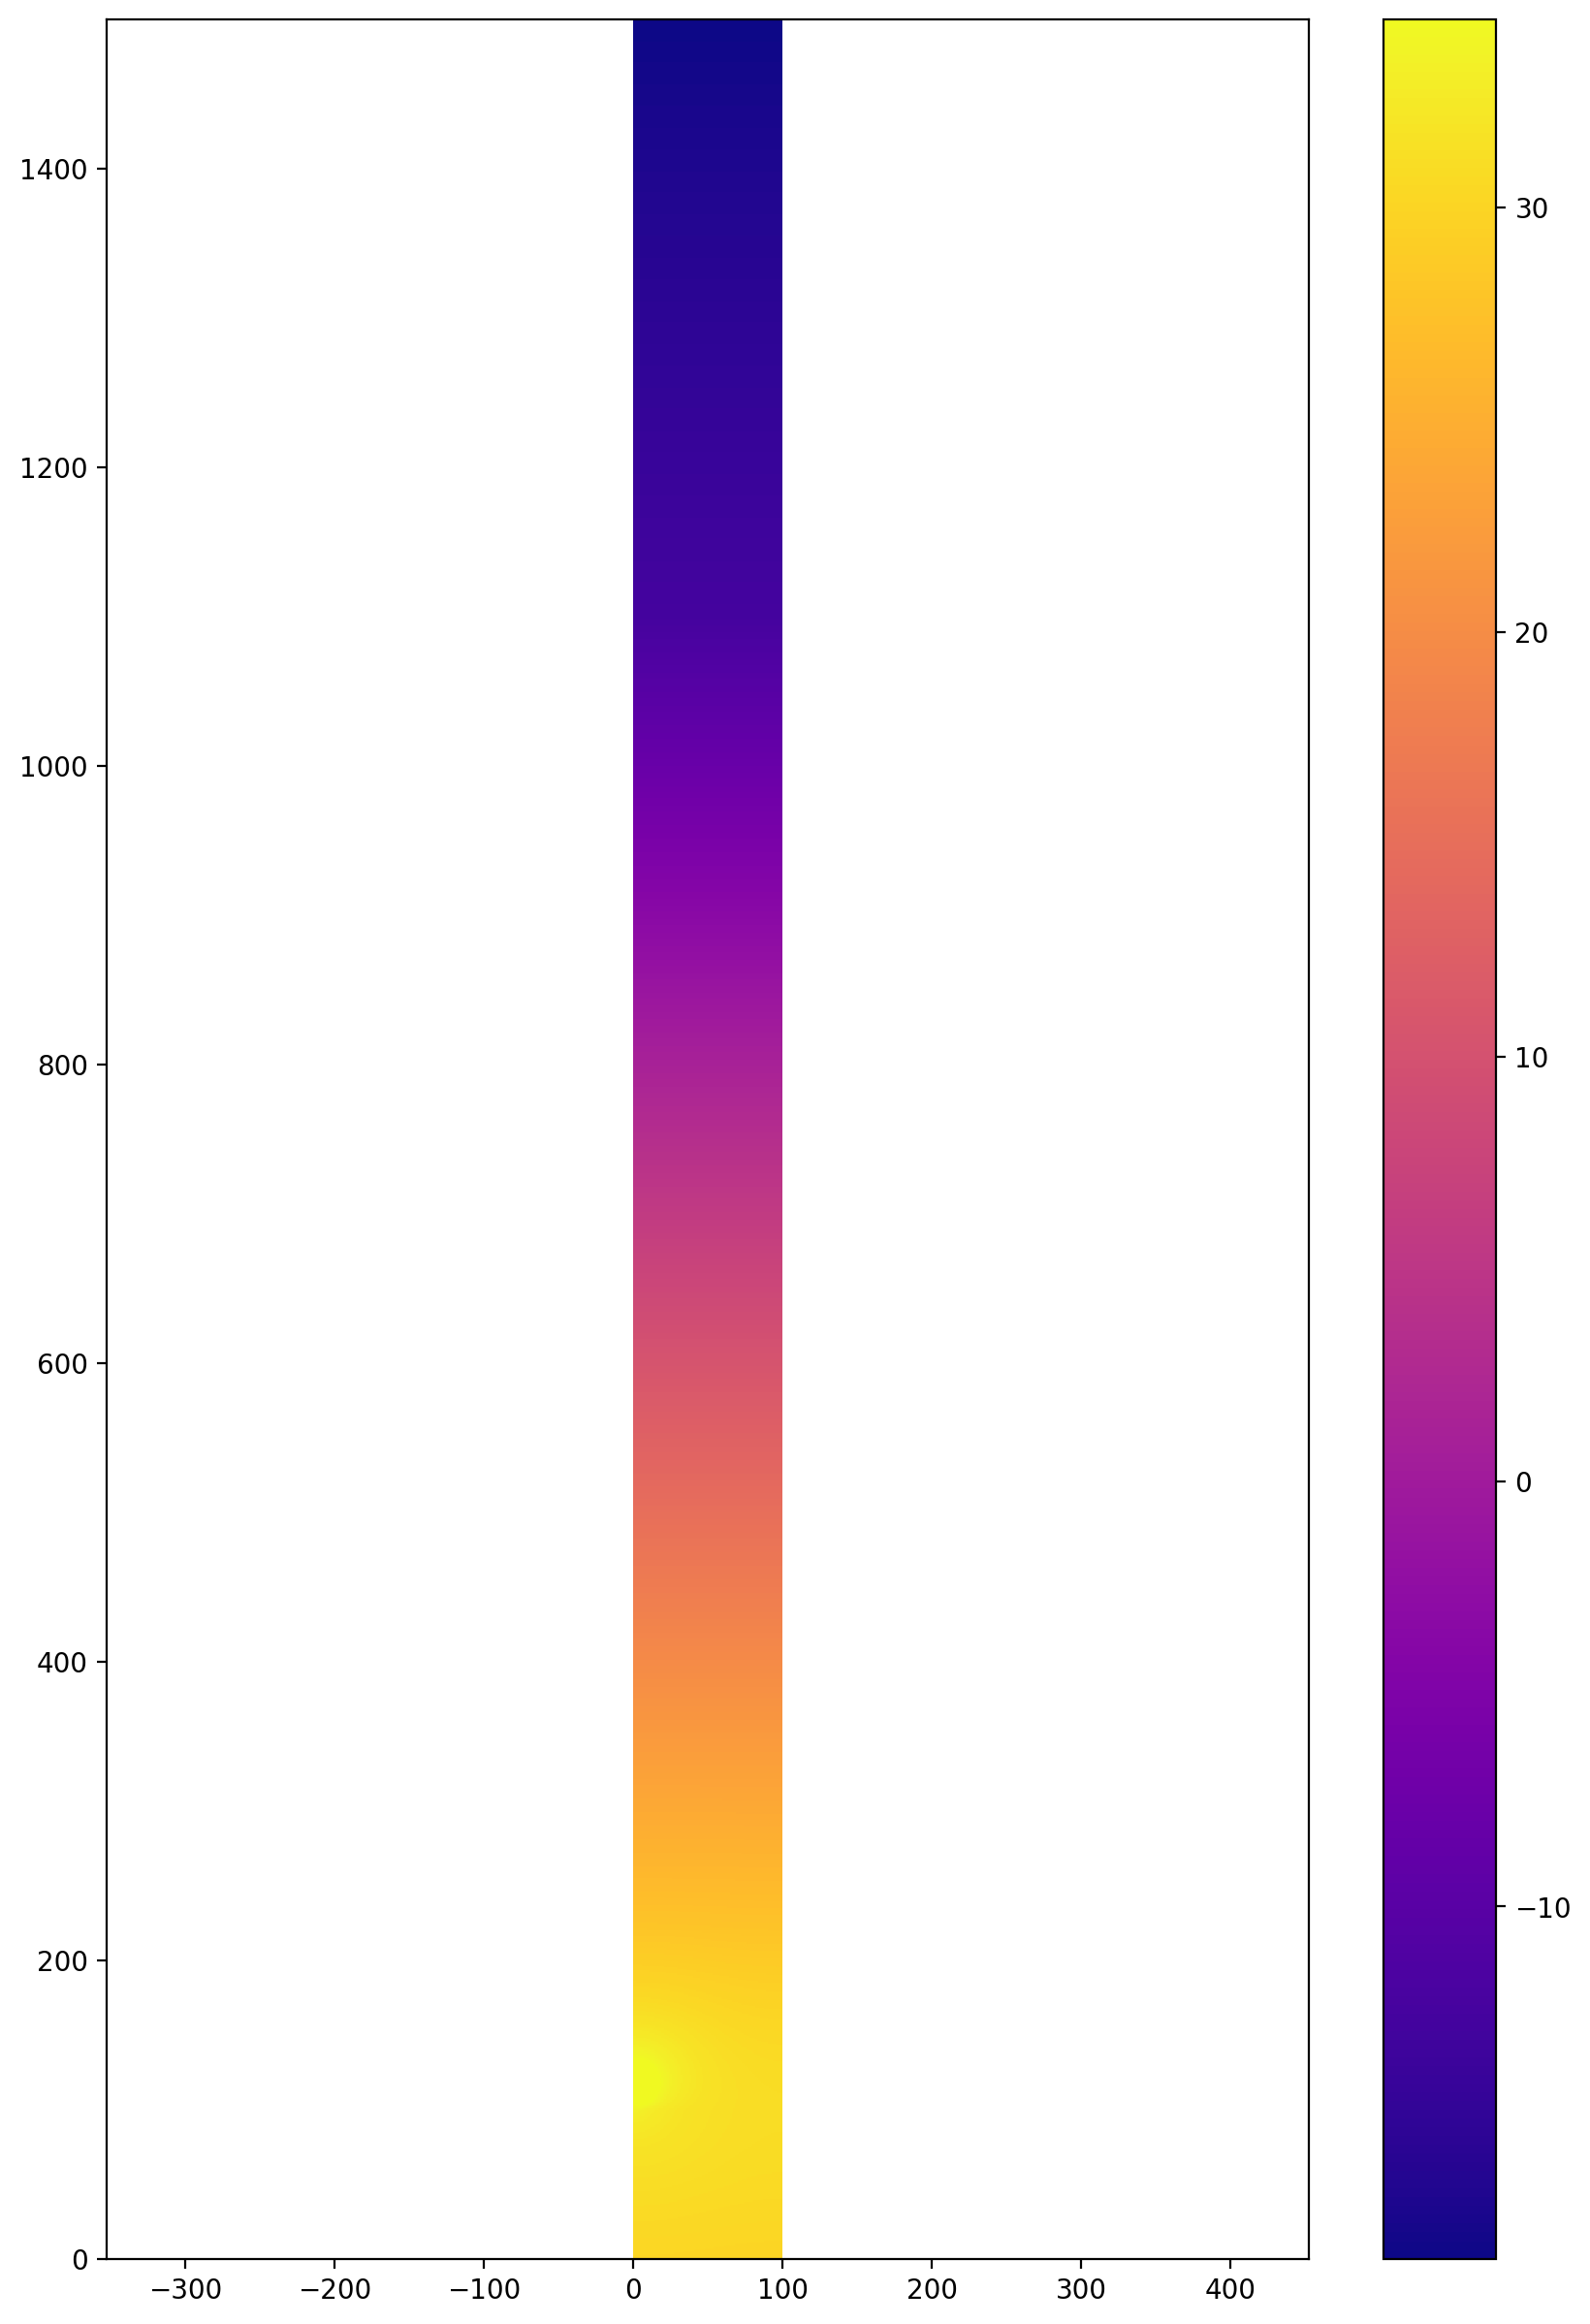

In [6]:
dx = 0.1
width = 10 #in mm, half of the capilary step

#Geometry variables from the bottom up
h1 = 10 
lambda1 = 0.3 #W/(m*K) #KANUF Thermoboard

h2 = 100
lambda2 = 0.037 #KNAUF TP 115
r1 = (3 / 2)  #inner r of capillay
r2 = (3.4 / 2)  #outer r
offset = 0 #offset to the start of the capillary
lambdaC = 0.22 #Polypropylene

h3 = 40 
lambda3 = 0.12 #wood


#Geometry input
geo = [[h1,lambda1],[h2,lambda2,[r1,r2,offset,lambdaC]],[h3,lambda3]]

#Geometry init
%time l, water_mask, center = init_l(dx, width, geo)

#Boundary conditions
q = 50 #[w/m^2]
t_top = -20
t_to_fit = 30
l_top = 10

#Linear system intit
%time A, b, pad = init_Ab(l, t_top, t_to_fit, water_mask, q, dx, l_top)


t_error = 0.001
maxiter = 10

%time T,t = t_fit_loop(A, b, pad, l, t_to_fit, t_error, maxiter, water_mask)
print(t)

plt.pcolormesh(T)
plt.axis('equal')
plt.colorbar()
plt.rcParams["figure.figsize"] = (6, 15)

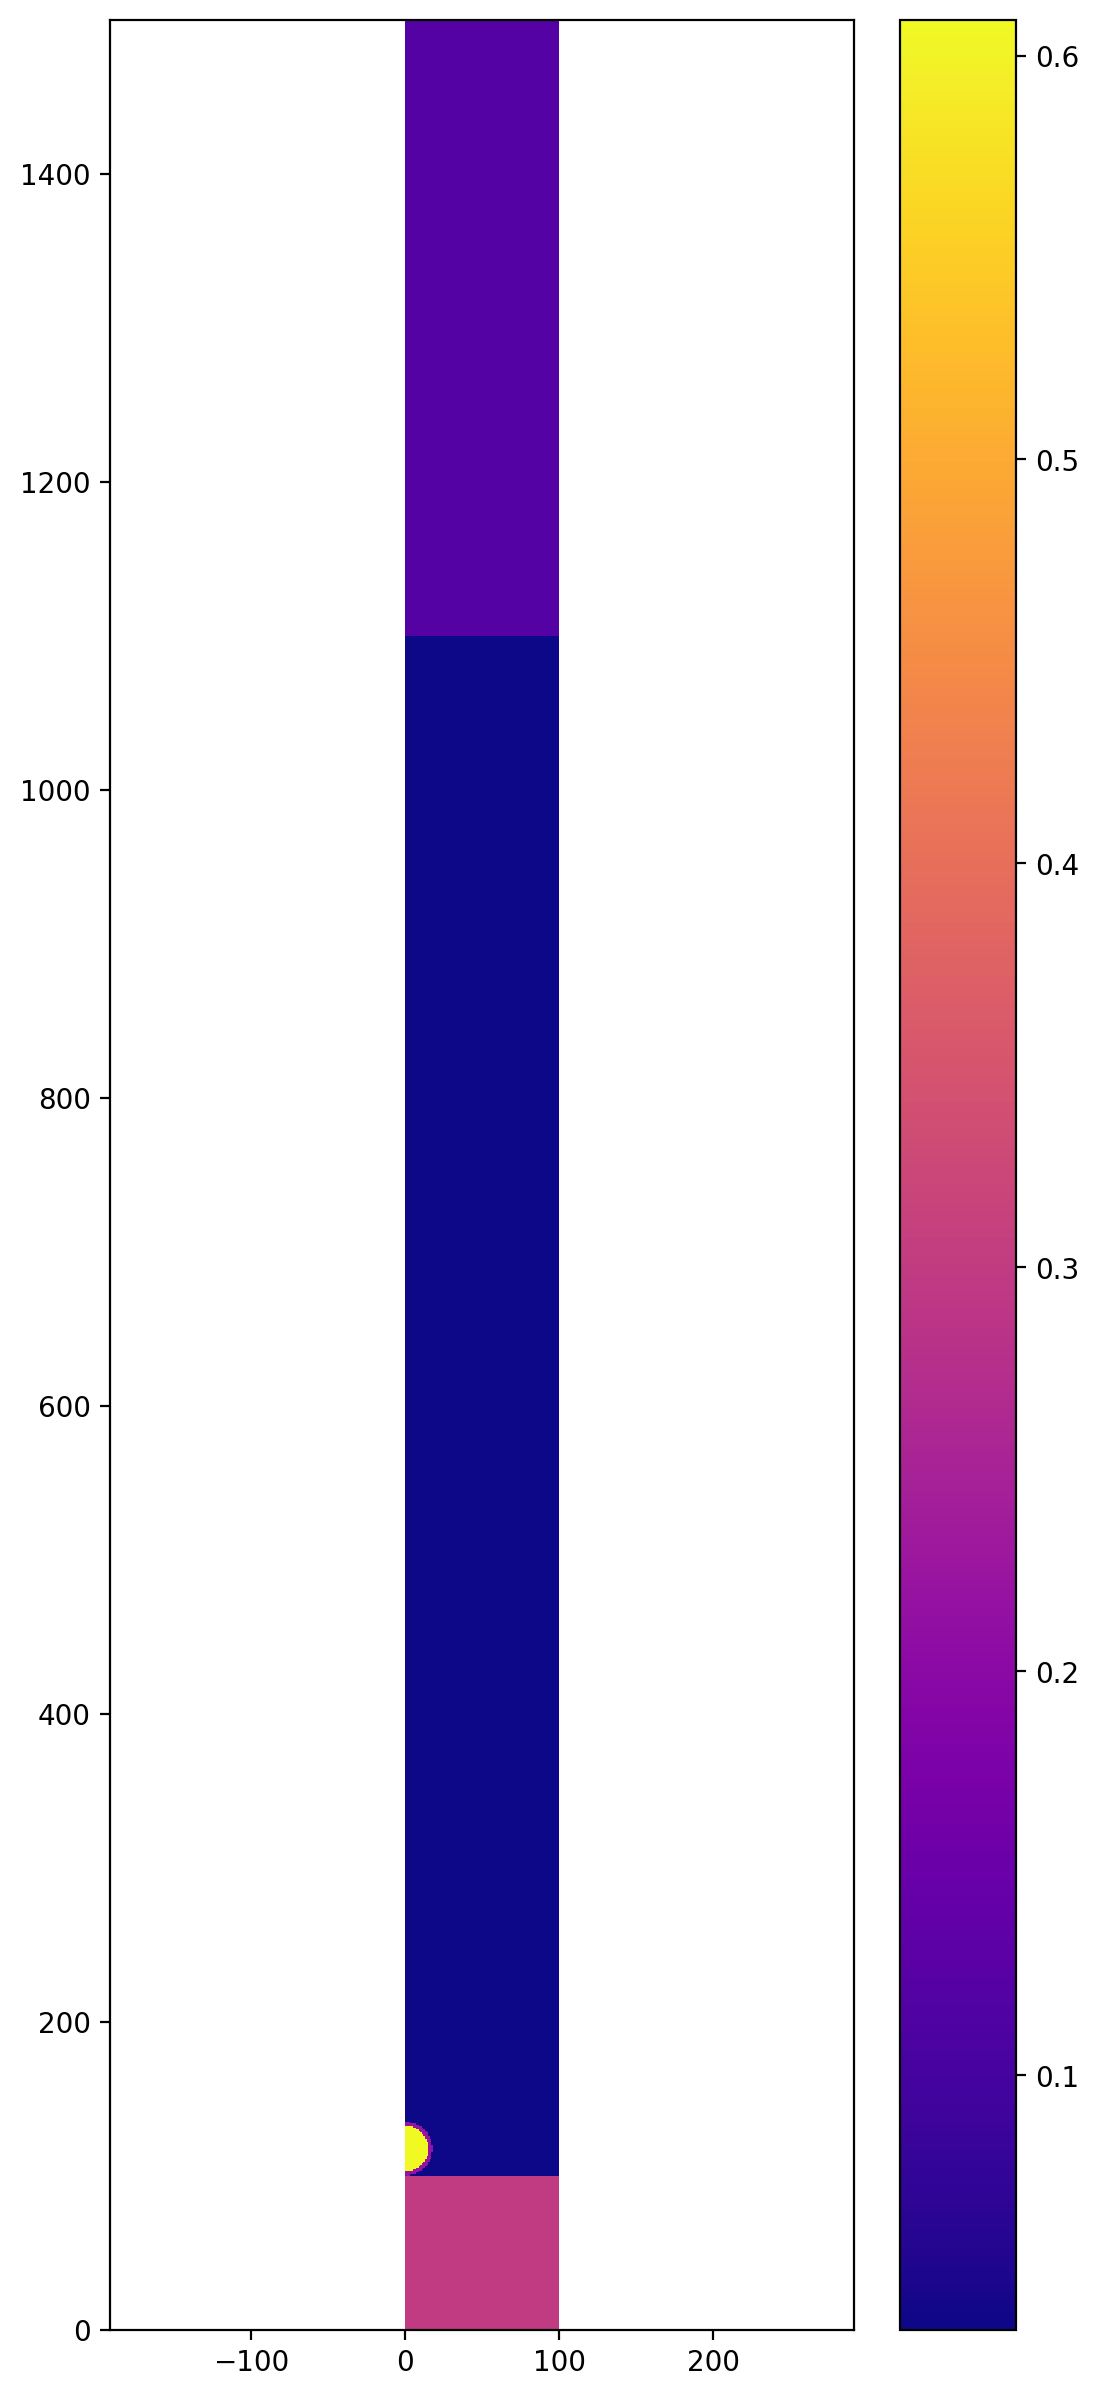

In [7]:
plt.pcolormesh(l)
plt.axis('equal')
plt.colorbar()
plt.rcParams["figure.figsize"] = (6, 15)

### Solve for a single steady state

CONSTANT BC
CPU times: user 1.89 s, sys: 44.4 ms, total: 1.94 s
Wall time: 1.95 s
CPU times: user 1.21 s, sys: 98.2 ms, total: 1.31 s
Wall time: 1.32 s


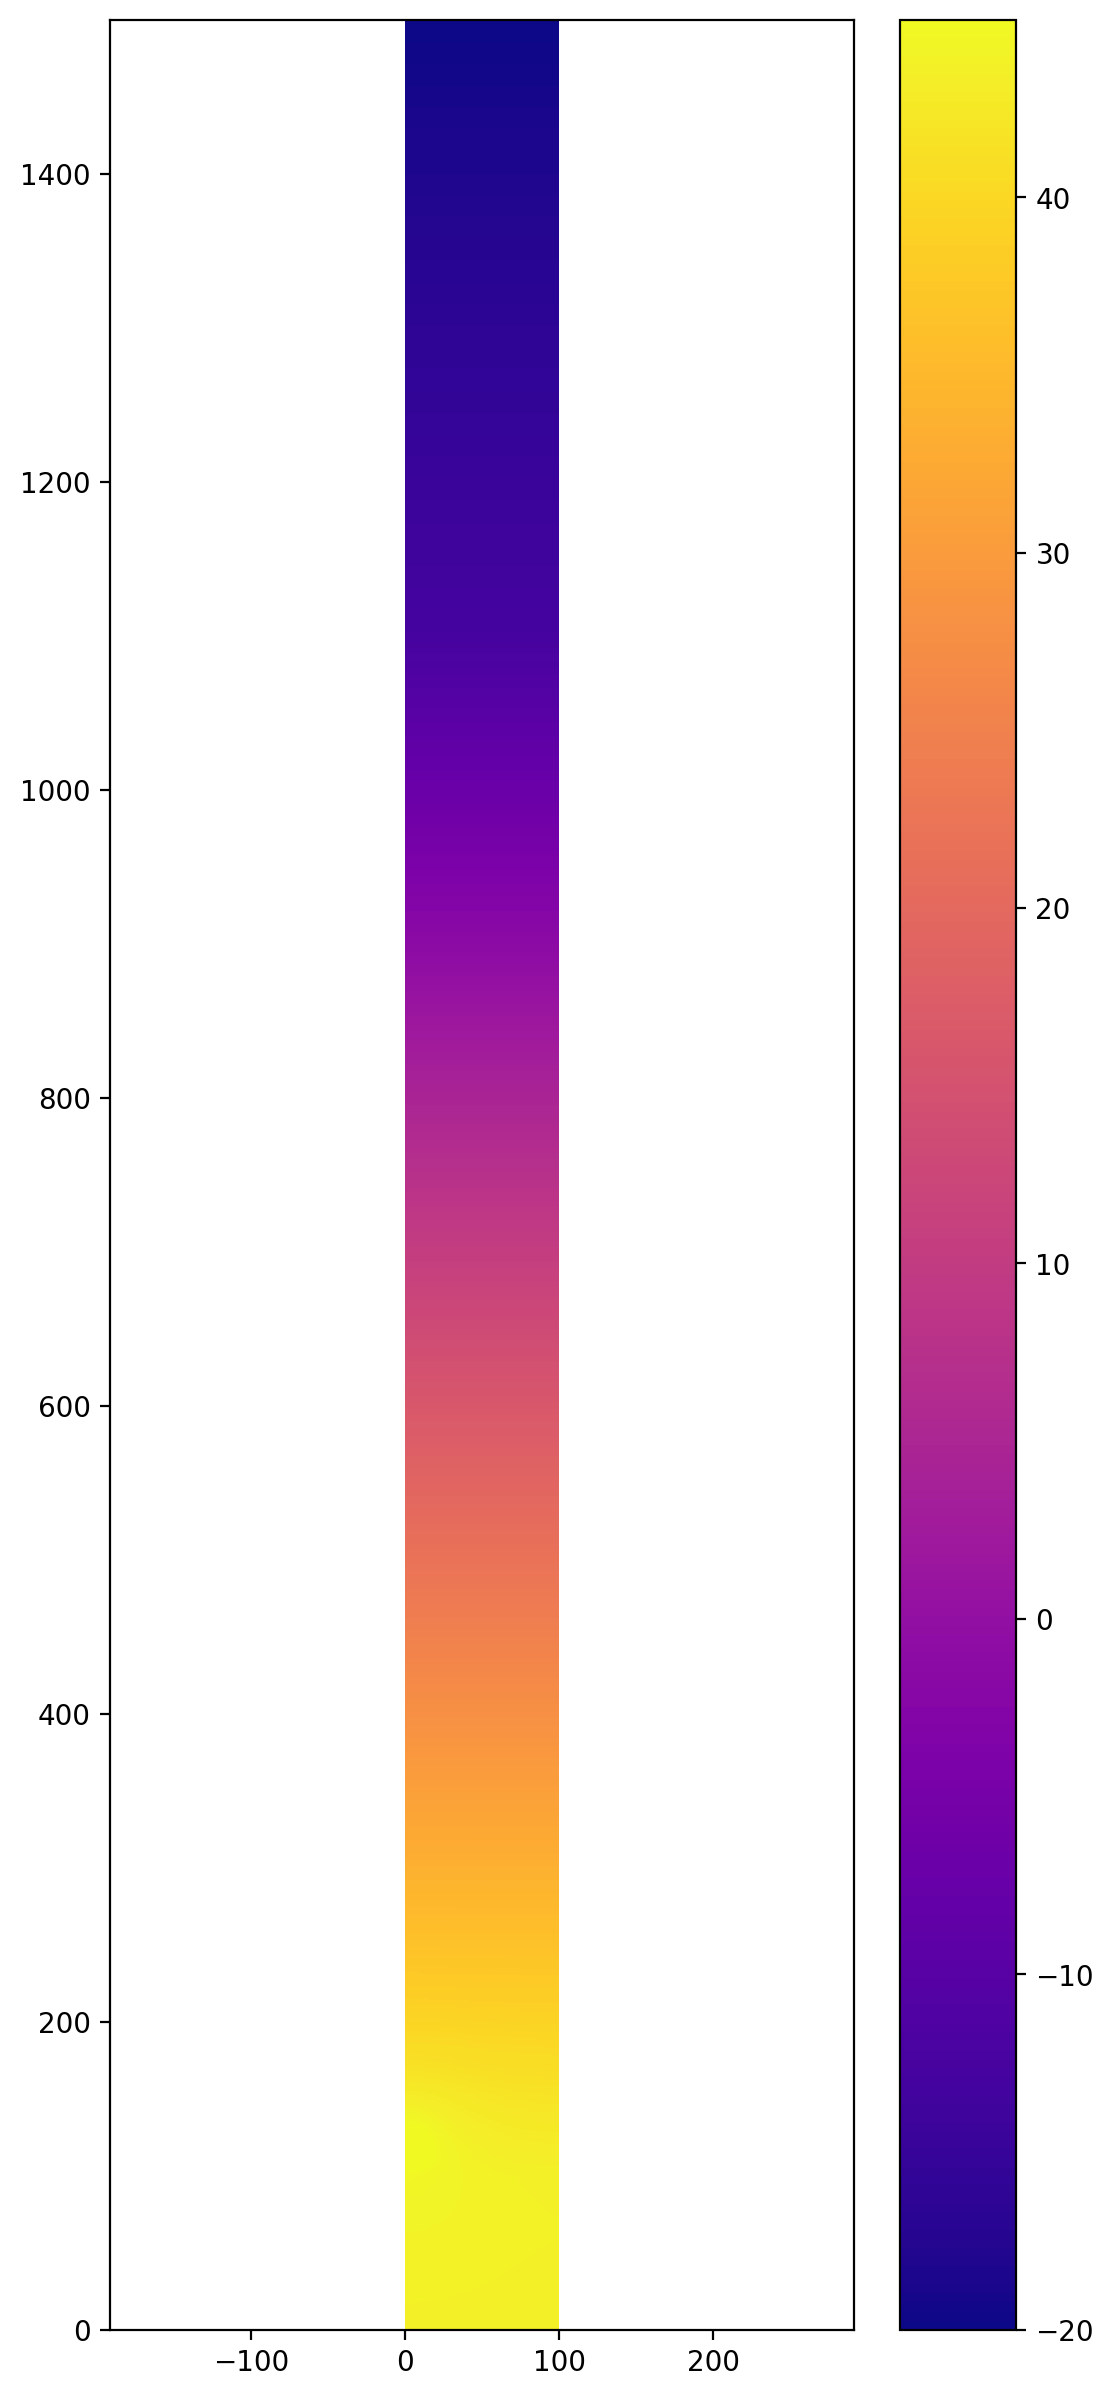

In [8]:
q = 10 #[w/m^2]
#l_top = 10 #[w/(m^2*k)]
#l_top = None
t_water = 45



%time A, b, pad = init_Ab(l, t_top, t_water, water_mask, q, dx)

# Solve the linear system
%time T = spsolve(A, b)

# Reshape the solution vector into a 2D array
ny, nx = l.shape
if pad == 2:
    T = T[nx:][:-nx].reshape((ny, nx))
else:
    T = T[nx:].reshape((ny, nx))


plt.pcolormesh(T)
plt.axis('equal')
plt.colorbar()

### Tiled visualisation

Text(0.5, 1.0, 'Temperature distribution')

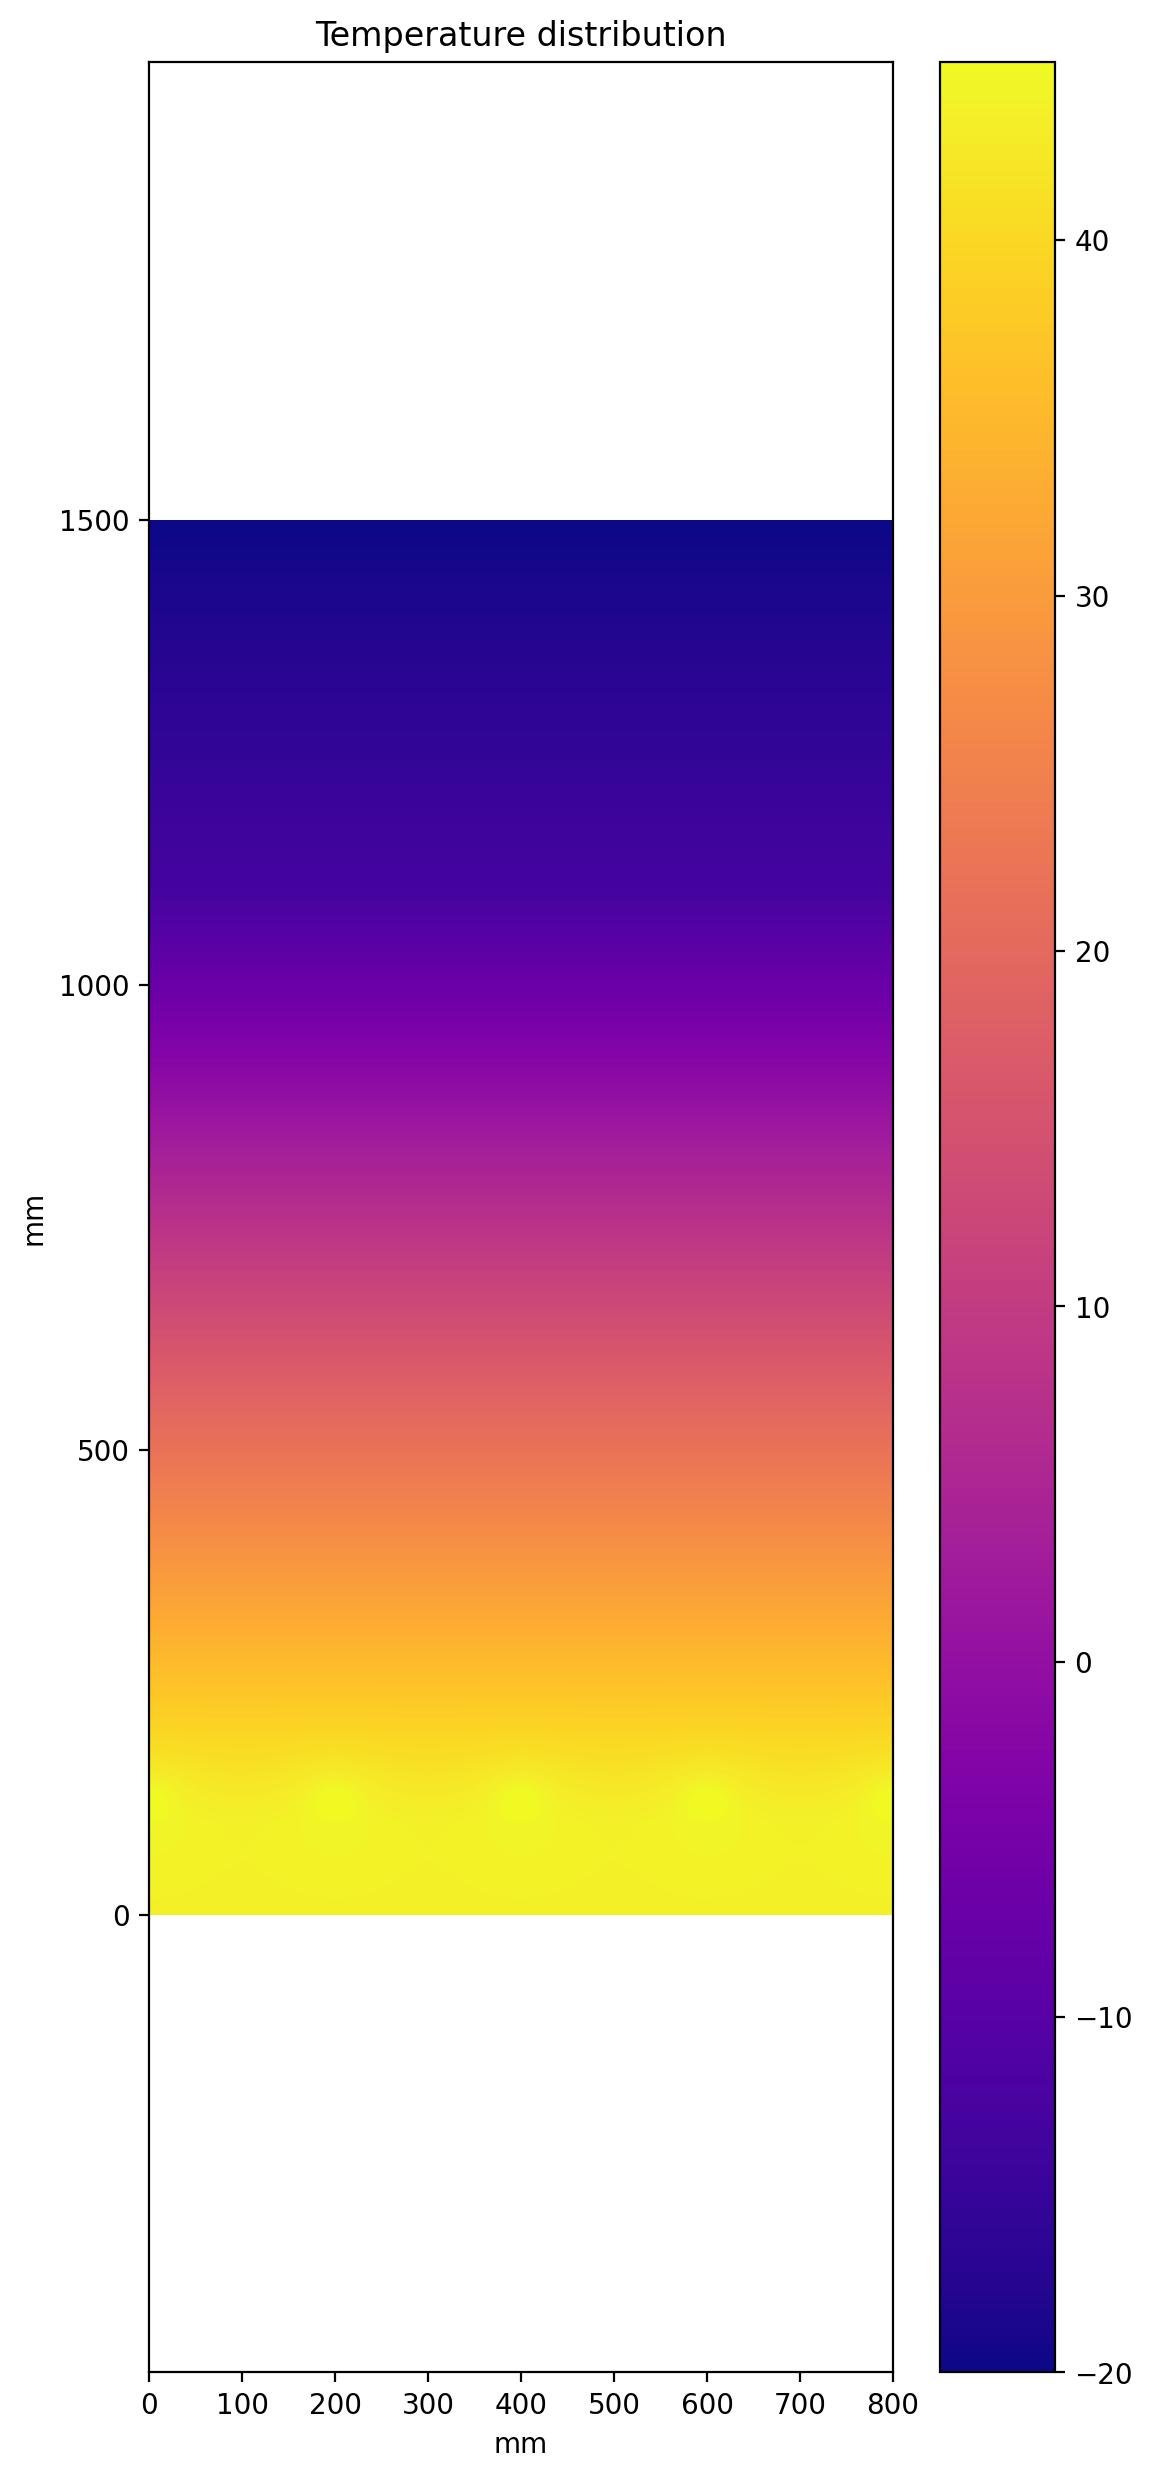

In [9]:
Tf = np.flip(T,1)
Ts = np.hstack((T,Tf,T,Tf,T,Tf,T,Tf))

plt.set_cmap("plasma")

plt.pcolormesh(Ts)
plt.axis('equal')
plt.colorbar()
plt.xlabel("mm")
plt.ylabel("mm")
plt.title("Temperature distribution")

Text(0.5, 1.0, 'Geometry in terms of lambda')

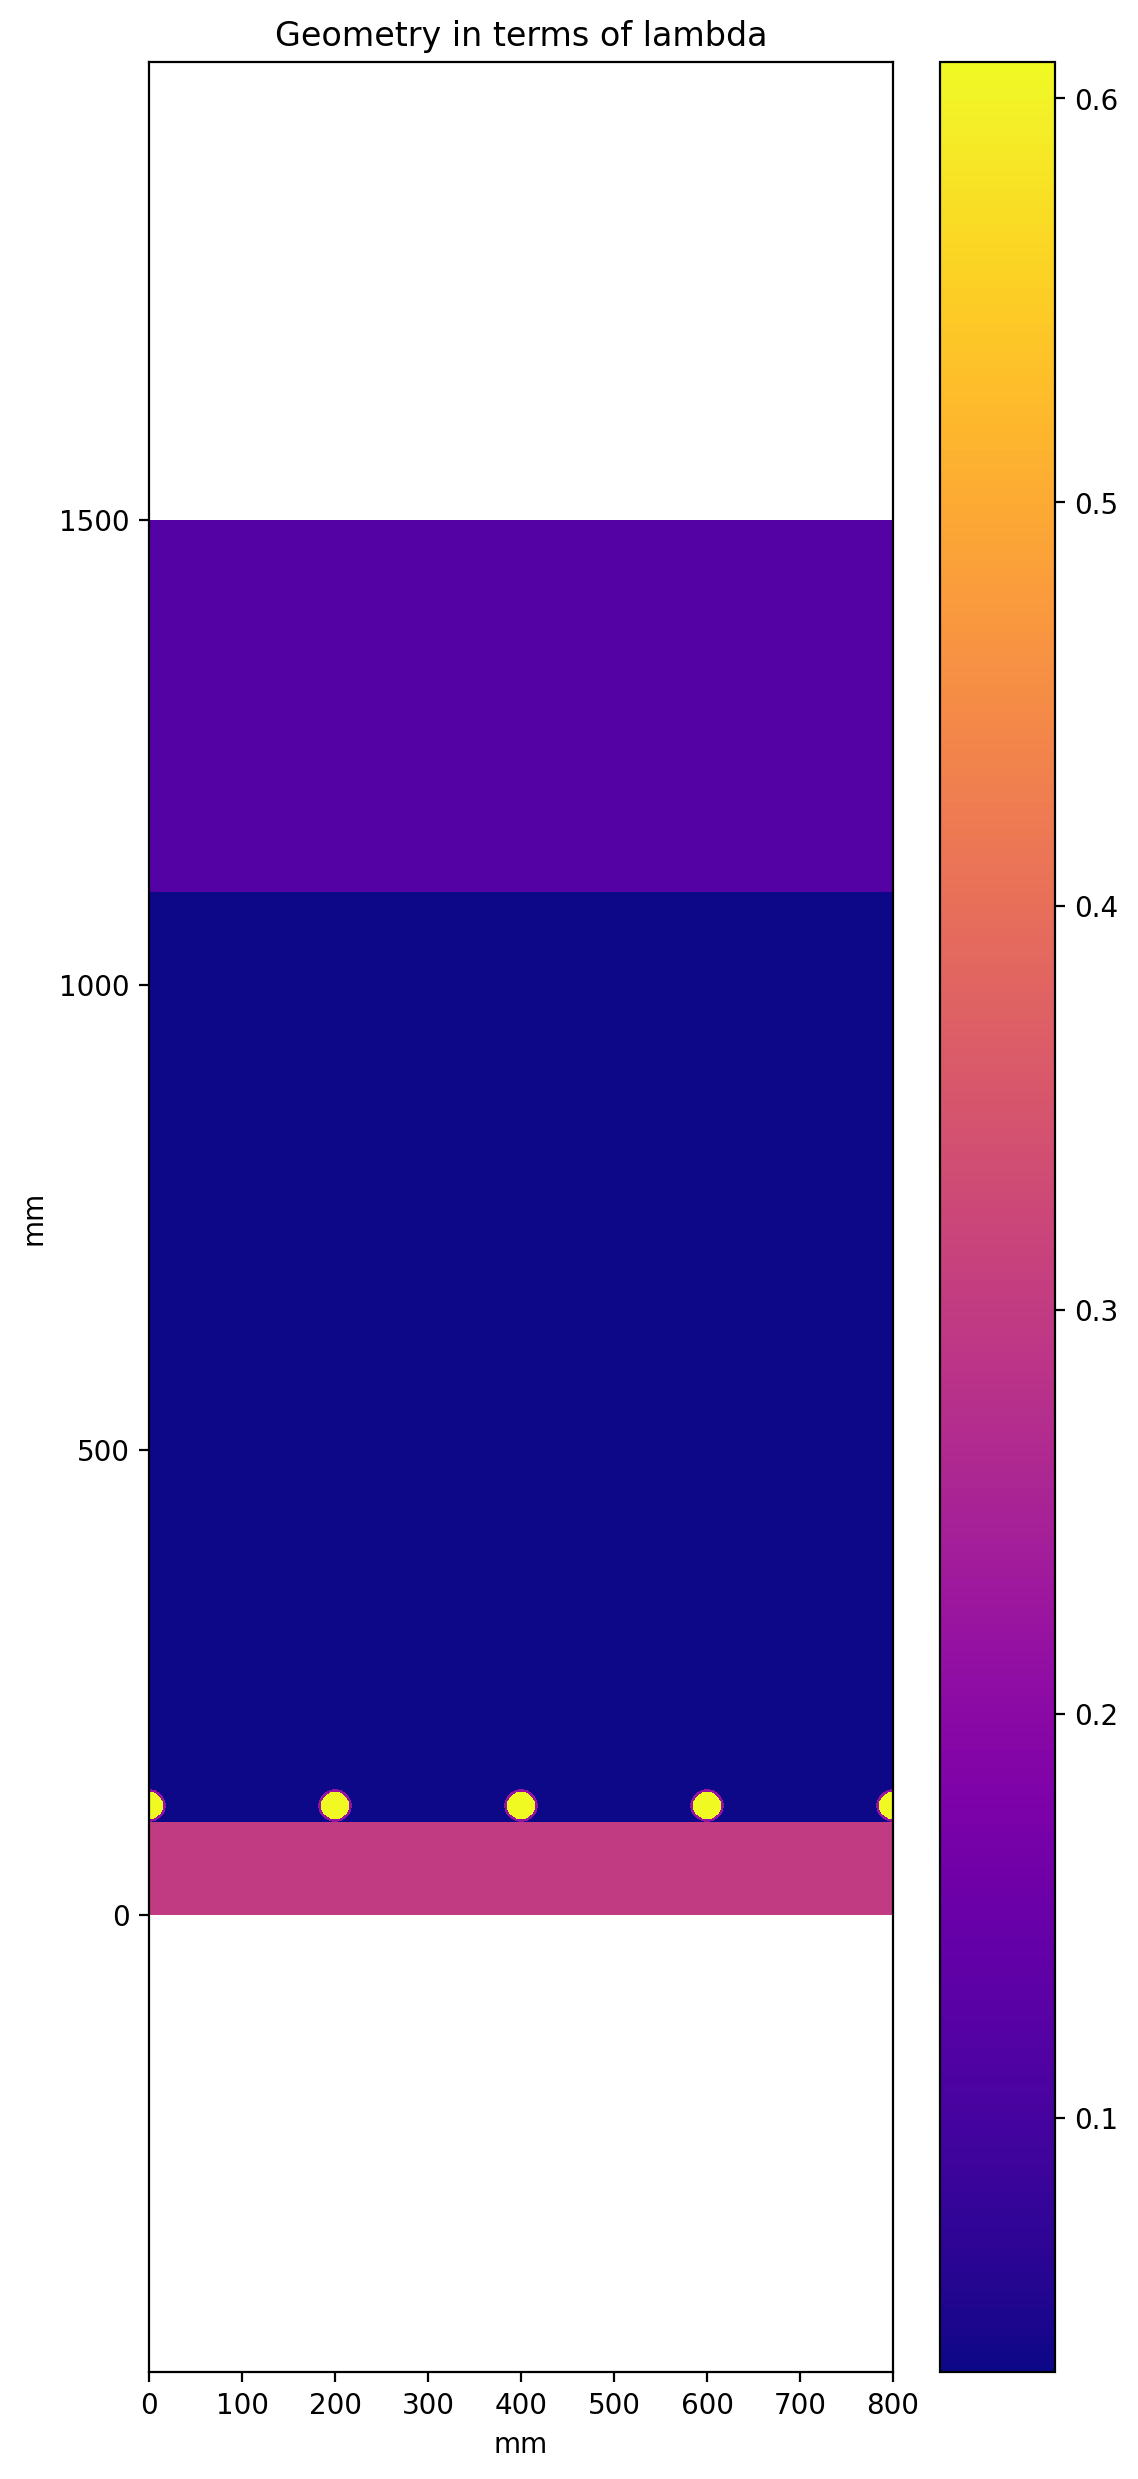

In [10]:
lf = np.flip(l,1)
ls = np.hstack((l,lf,l,lf,l,lf,l,lf))

plt.pcolormesh(ls)

plt.xlabel("mm")
plt.ylabel("mm")

plt.axis('equal')
plt.colorbar()
plt.title("Geometry in terms of lambda")

### Temperature around the capillary

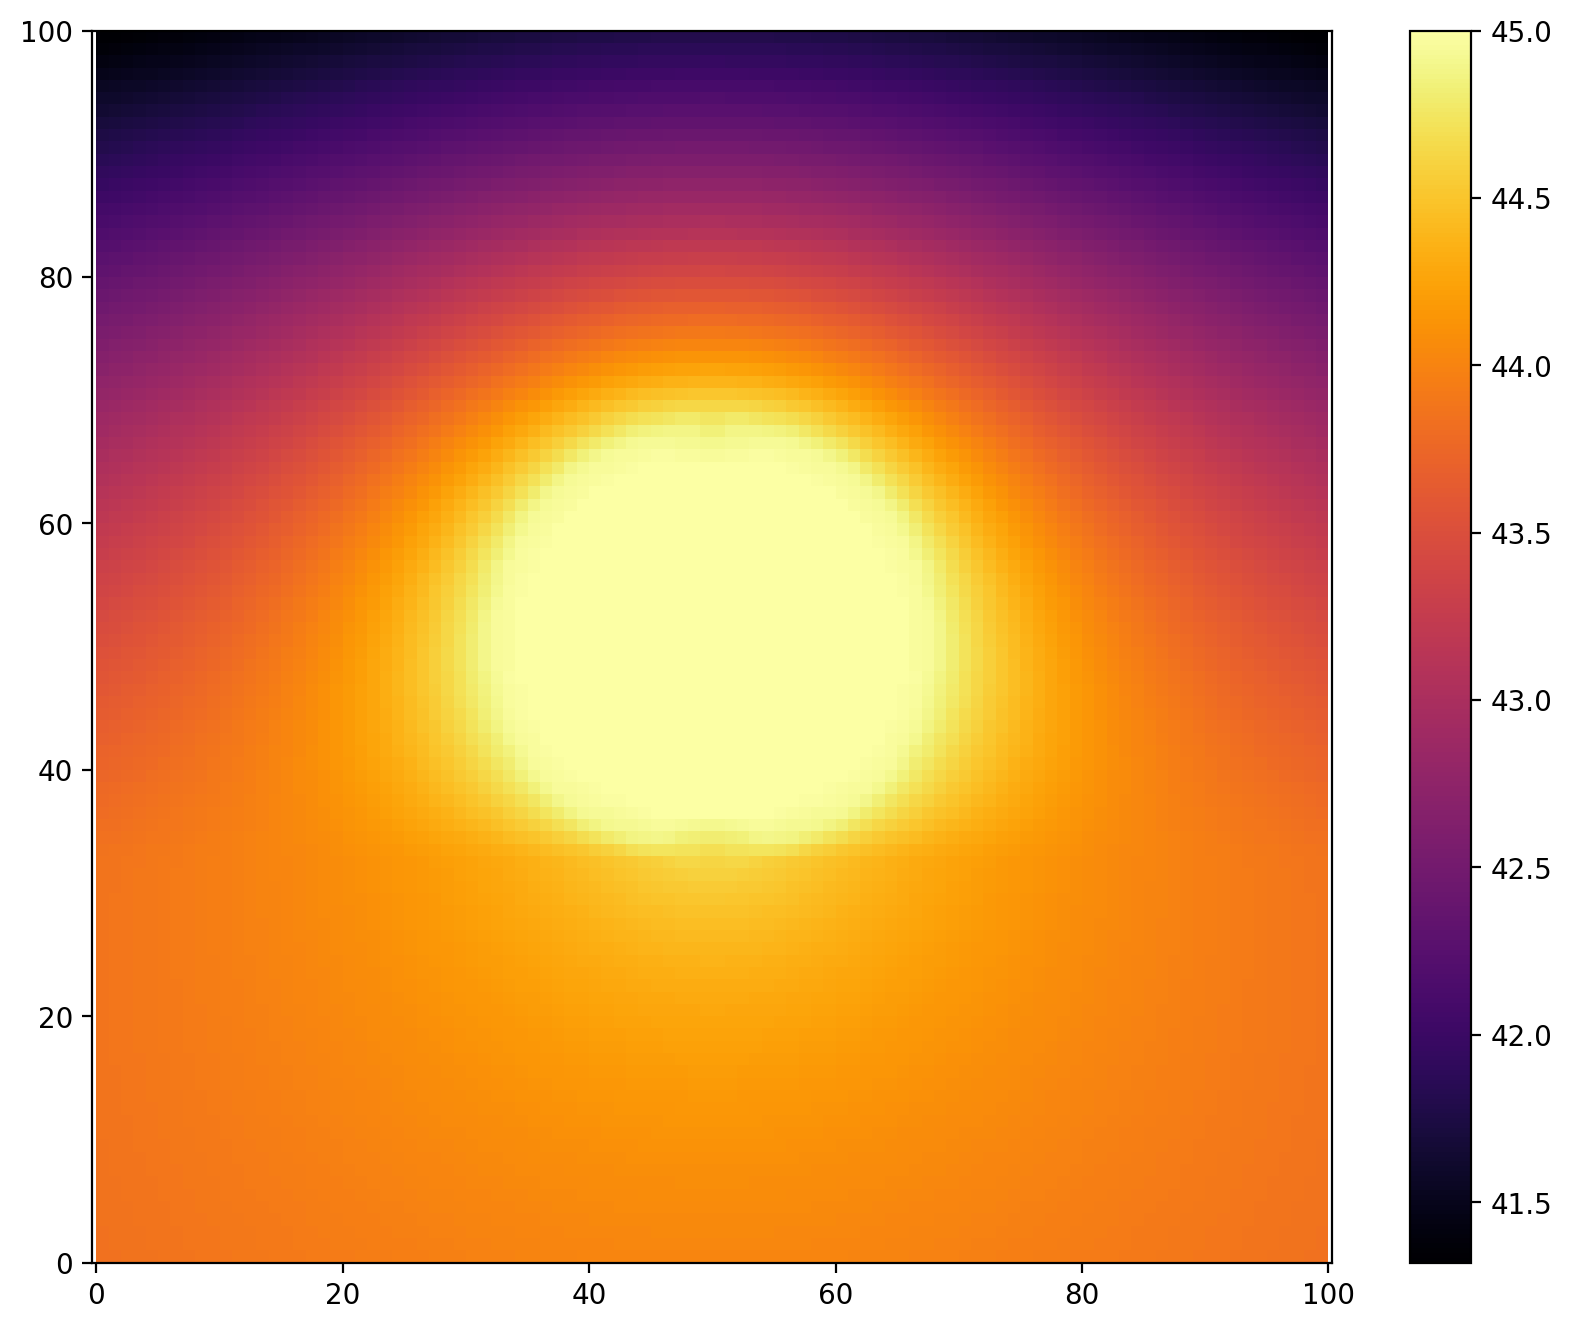

In [11]:
size = 50
bottom = int(center-size)
top = int(center+size)
plt.rcParams["figure.figsize"] = (10, 8)
plt.pcolormesh(Ts[bottom:top,150:250], cmap = 'inferno')
plt.axis('equal')
plt.colorbar()

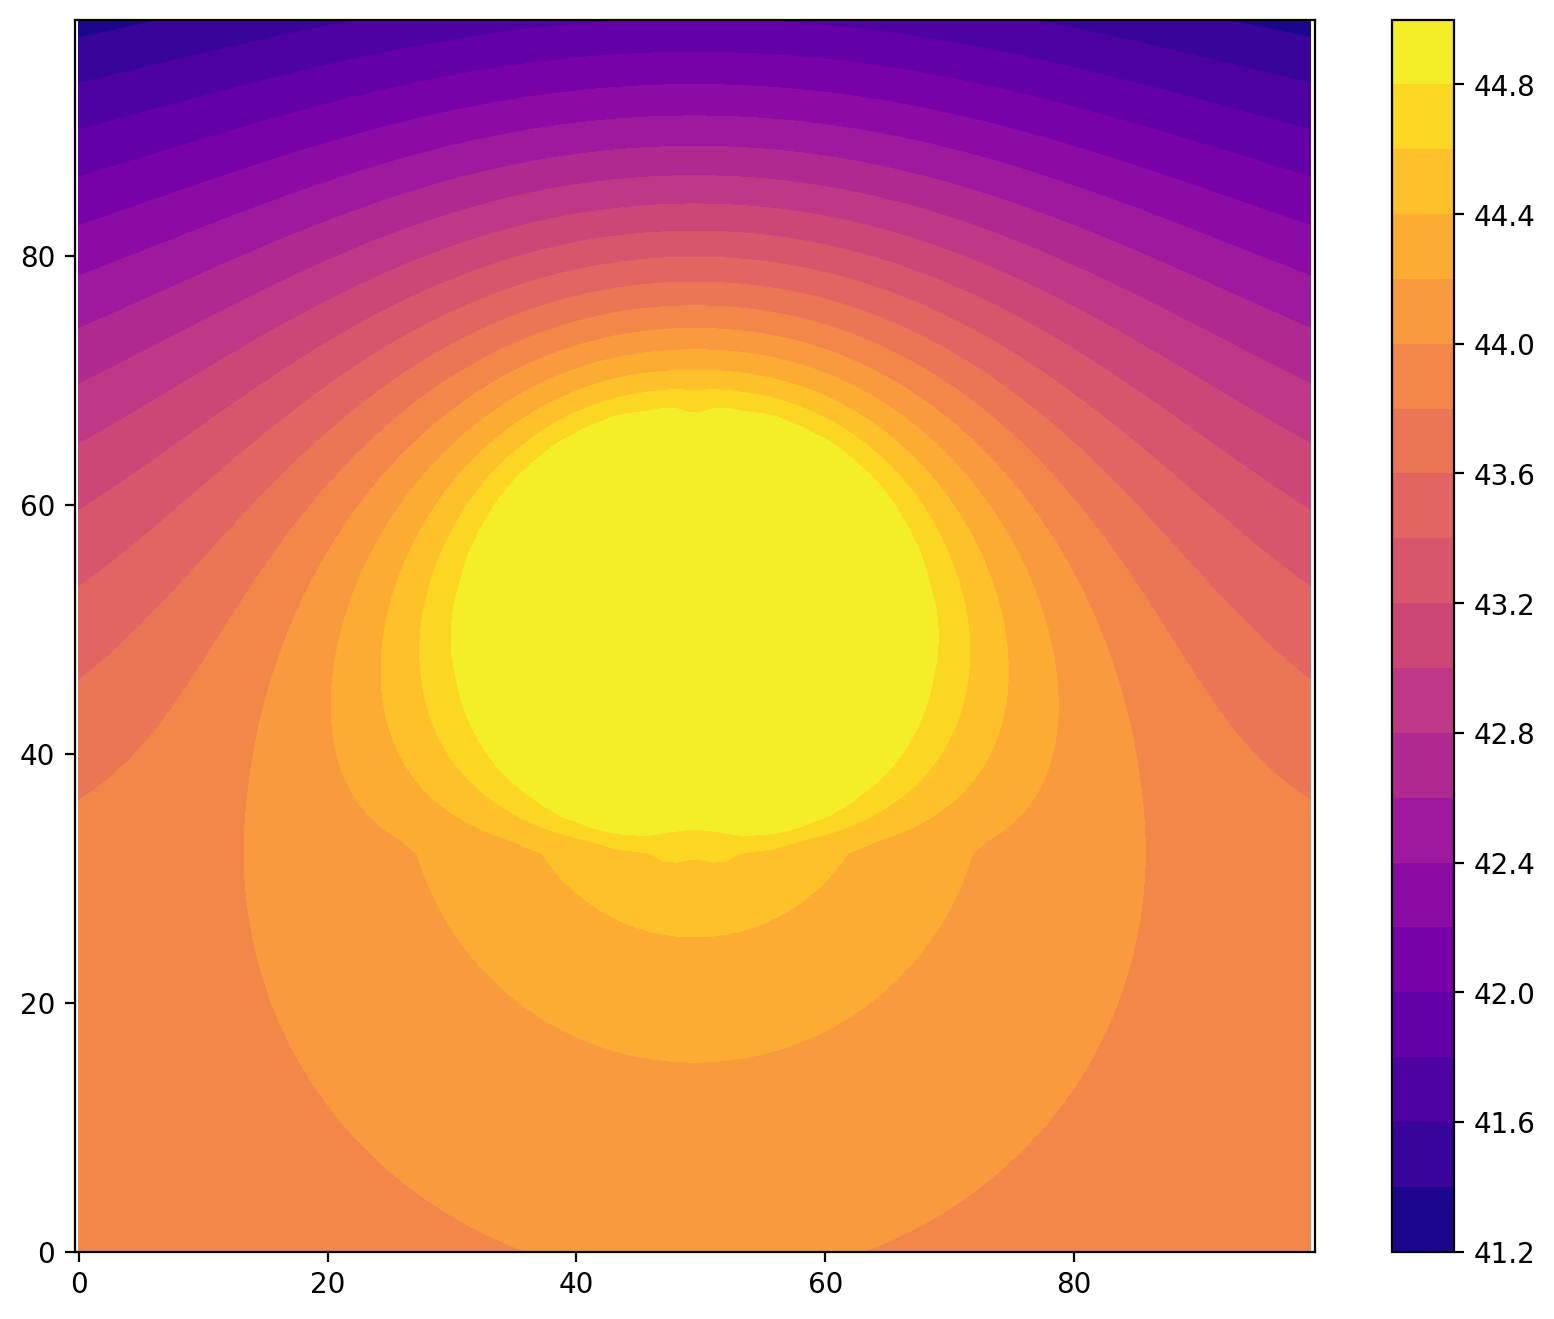

In [12]:
plt.contourf(Ts[bottom:top,150:250], cmap = 'plasma', levels = 20)
plt.axis('equal')
plt.colorbar()

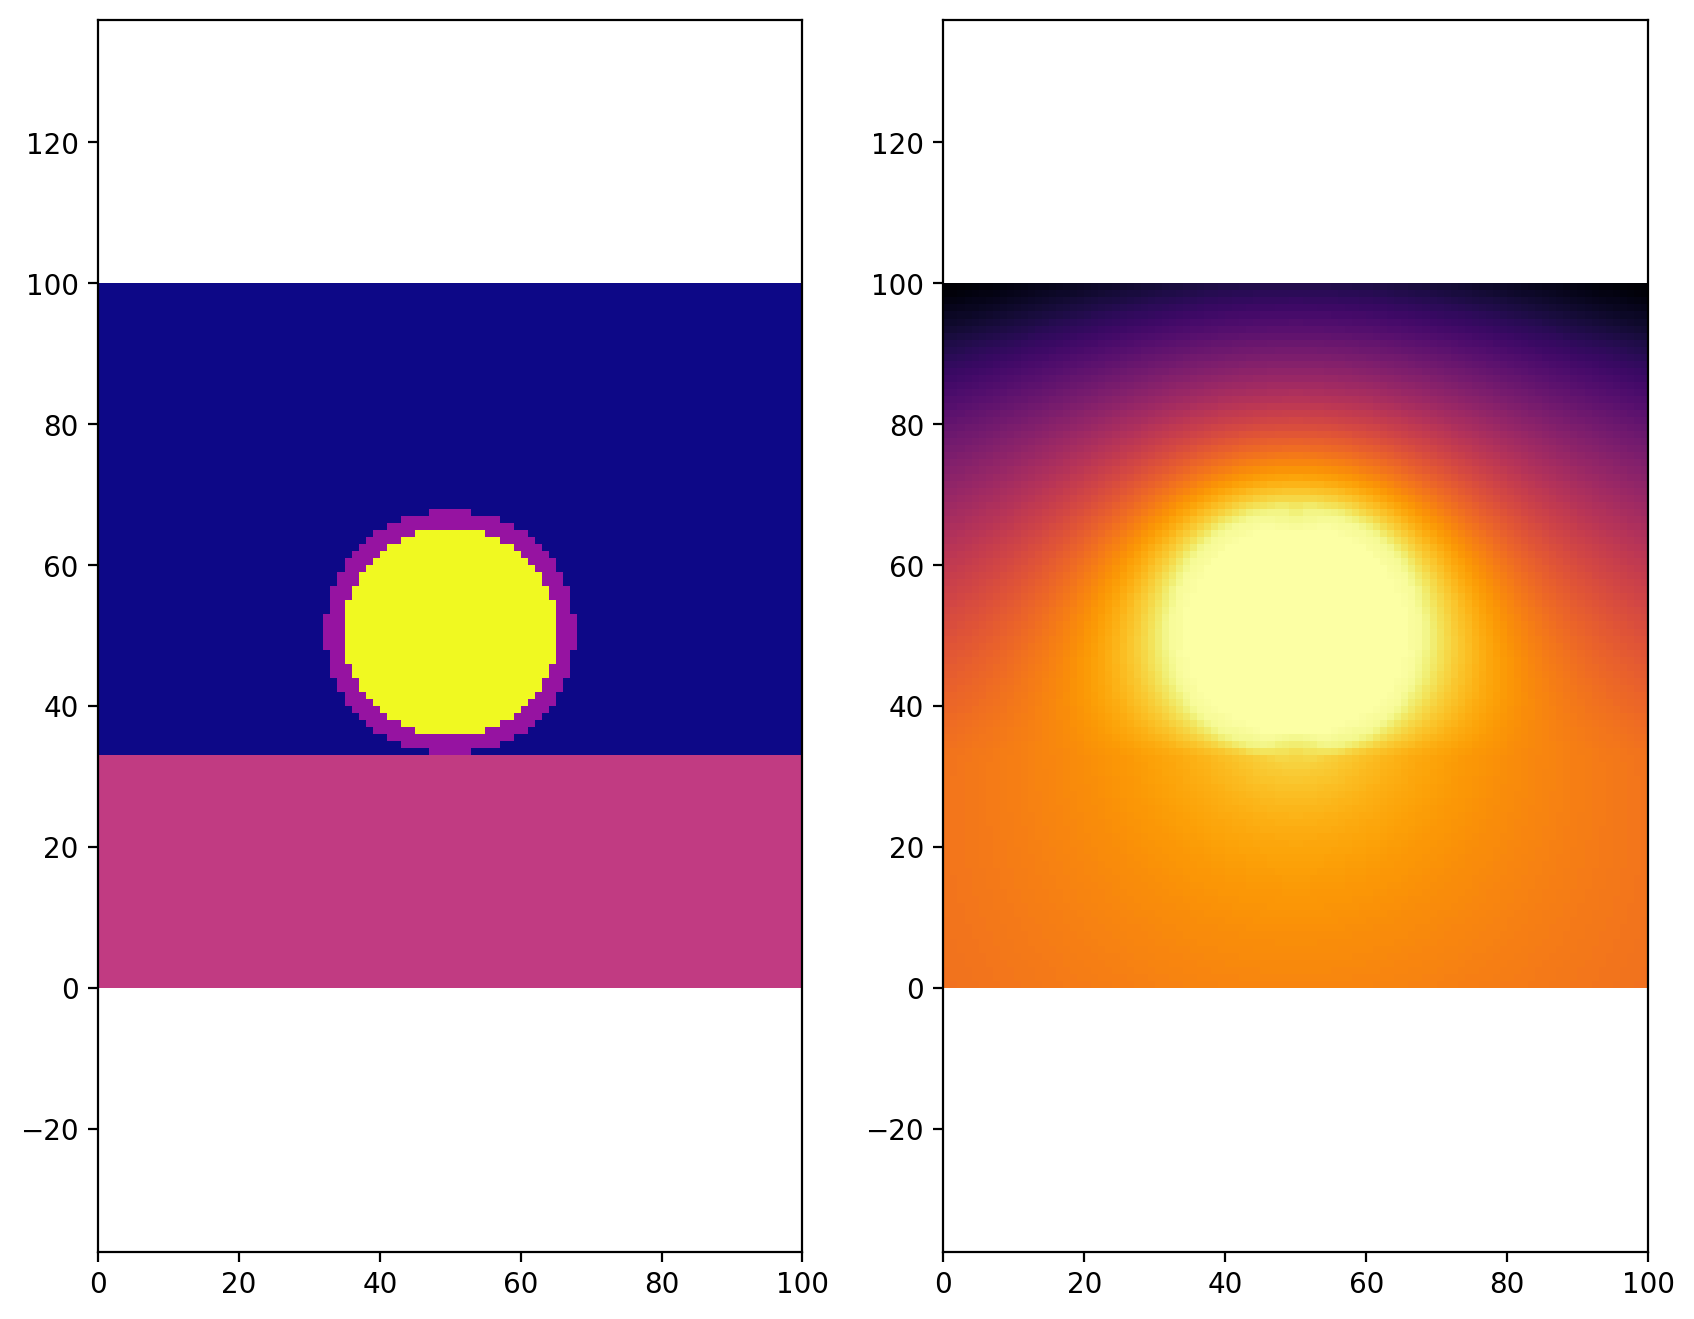

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
mesh = ax1.pcolormesh(ls[bottom:top,150:250], cmap = 'plasma')
ax1.axis('equal')

layers = ax2.pcolormesh(Ts[bottom:top,150:250], cmap = 'inferno')
ax2.axis('equal')
plt.rcParams["figure.figsize"] = (8, 4)

#plt.savefig("capillary geo and temp.png")